In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import tempfile

from dosemetrics import Dose
from dosemetrics.io import load_structure_set
from dosemetrics.metrics import dvh

# Create temporary directory for outputs
temp_dir = Path(tempfile.mkdtemp(prefix="dosemetrics_"))
print(f"✓ Using temporary directory for outputs: {temp_dir}")

## 1. Load Sample Data

Load a dose distribution and structure mask:

In [2]:
from huggingface_hub import snapshot_download

# Download the dataset (cached locally after first download)
data_path = Path(snapshot_download(
    repo_id="contouraid/dosemetrics-data",
    repo_type="dataset"
))

print(f"✓ Data downloaded to: {data_path}")

# Set the subject path for this tutorial
subject_path = data_path / "test_subject"
print(f"✓ Using subject data from: {subject_path}")

/Users/amithkamath/Repositories/ContourAId/dosemetrics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 165 files: 100%|██████████| 165/165 [00:00<00:00, 282128.07it/s]

✓ Data downloaded to: /Users/amithkamath/.cache/huggingface/hub/datasets--contouraid--dosemetrics-data/snapshots/839ceab7ba71766265fd6a637fe799341bb0364f
✓ Using subject data from: /Users/amithkamath/.cache/huggingface/hub/datasets--contouraid--dosemetrics-data/snapshots/839ceab7ba71766265fd6a637fe799341bb0364f/test_subject


# Basic Usage of DoseMetrics

This notebook demonstrates the basic workflow for loading radiotherapy data and computing dosimetric metrics using the DoseMetrics library.

## Setup

First, let's download example data from HuggingFace:

In [3]:
# Load dose using Dose class
dose_file = subject_path / "Dose.nii.gz"
dose = Dose.from_nifti(dose_file, name="Clinical")
print(f"Dose shape: {dose.shape}")
print(f"Dose range: {dose.min_dose:.2f} - {dose.max_dose:.2f} Gy")
print(f"Voxel spacing (mm): {dose.spacing}")

# Load all structures from the folder
structure_set = load_structure_set(subject_path)
print(f"\nLoaded {len(structure_set)} structures")

# Access a specific structure (PTV - Planning Target Volume)
ptv = structure_set.get_structure("PTV")
print(f"\nPTV volume: {ptv.volume_cc():.2f} cc")
print(f"PTV type: {ptv.structure_type}")

Dose shape: (128, 128, 128)
Dose range: -0.92 - 64.45 Gy
Voxel spacing (mm): (2.0, 2.0, 2.0)

Loaded 16 structures

PTV volume: 343.03 cc
PTV type: StructureType.TARGET


## 2. Compute DVH

In [4]:
# Compute DVH for the PTV
bins, values = dvh.compute_dvh(dose, ptv, max_dose=70, step_size=0.1)

# Convert to DataFrame for easier viewing
dvh_df = pd.DataFrame({
    'Dose (Gy)': bins,
    'Volume (%)': values
})
print(dvh_df.head(10))

   Dose (Gy)  Volume (%)
0        0.0       100.0
1        0.1       100.0
2        0.2       100.0
3        0.3       100.0
4        0.4       100.0
5        0.5       100.0
6        0.6       100.0
7        0.7       100.0
8        0.8       100.0
9        0.9       100.0


## 3. Visualize DVH

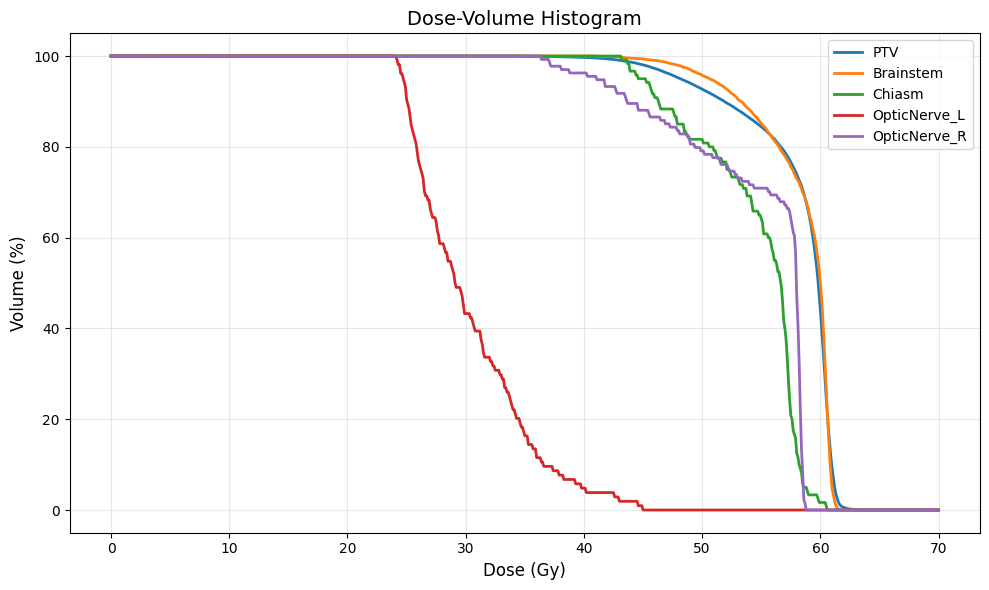

In [5]:
# Plot DVH for all structures
import matplotlib.pyplot as plt

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

for structure_name in ['PTV', 'Brainstem', 'Chiasm', 'OpticNerve_L', 'OpticNerve_R']:
    if structure_name in structure_set:
        structure = structure_set.get_structure(structure_name)
        bins, values = dvh.compute_dvh(dose, structure, max_dose=70, step_size=0.1)
        ax.plot(bins, values, label=structure_name, linewidth=2)

ax.set_xlabel('Dose (Gy)', fontsize=12)
ax.set_ylabel('Volume (%)', fontsize=12)
ax.set_title('Dose-Volume Histogram', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Export Results

In [ ]:
# Compute DVH for all structures and save to CSV
dvh_all = dvh.create_dvh_table(dose, structure_set, max_dose=70, step_size=0.1)
print(dvh_all.head(20))

# Save to CSV in temporary directory
output_file = temp_dir / "dvh_results.csv"
dvh_all.to_csv(output_file, index=False)
print(f"\n✓ Results saved to {output_file}")
print(f"✓ All outputs are in temporary directory: {temp_dir}")

    Dose     Structure  Volume
0    0.0  OpticNerve_L   100.0
1    0.1  OpticNerve_L   100.0
2    0.2  OpticNerve_L   100.0
3    0.3  OpticNerve_L   100.0
4    0.4  OpticNerve_L   100.0
5    0.5  OpticNerve_L   100.0
6    0.6  OpticNerve_L   100.0
7    0.7  OpticNerve_L   100.0
8    0.8  OpticNerve_L   100.0
9    0.9  OpticNerve_L   100.0
10   1.0  OpticNerve_L   100.0
11   1.1  OpticNerve_L   100.0
12   1.2  OpticNerve_L   100.0
13   1.3  OpticNerve_L   100.0
14   1.4  OpticNerve_L   100.0
15   1.5  OpticNerve_L   100.0
16   1.6  OpticNerve_L   100.0
17   1.7  OpticNerve_L   100.0
18   1.8  OpticNerve_L   100.0
19   1.9  OpticNerve_L   100.0

✓ Results saved to dvh_results.csv


## Try the Live Demo

Want to experiment without setting up data? Try our [interactive demo on Hugging Face](https://huggingface.co/spaces/contouraid/dosemetrics)!